In [1]:
%%capture
%pip install datasets transformers

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader
import numpy as np
from typing import List, Optional
import unicodedata
import re
import matplotlib.pyplot as plt

# Transformer from scratch

In this notebook we are going to code a GPT model from scratch.

We will do that in a modular way, and increase the difficulty step by step.

:red_circle: **WARNING** :red_circle: **You are not allowed to use any existing pre-built torch module, like `nn.Linear`.** You can only use pytorch `Tensor` and the module you create.

## Basic transformer block

![](https://drive.google.com/uc?export=view&id=1dlkXQtGtZwoHribpTeQ0MeoNdwoiYJOo)

In this first part, we are going to build the grey block. We are going to write this step by step.

🚧 **TODO** 🚧

Which submodules do we need to write? Propose an architecture for each of them, and keep it as simple as possible.



In [3]:
class Embeddings(nn.Module):
    def __init__(self, vocab_size, d):
        # TODO
        super().__init__()
        embeddings = 0.02 * torch.randn(vocab_size, d)
        self.embeddings = nn.Parameter(embeddings)

    def forward(self, x):
        return self.embeddings[x]


class Linear(nn.Module):
    def __init__(self, d_in, d_out, bias=True):
        # TODO
        super().__init__()
        self.matrix = nn.Parameter(0.02 * torch.randn(d_in, d_out))
        if bias:
            self.bias = nn.Parameter(0.02 * torch.randn(d_out))

    def forward(self, x):
        results = x @ self.matrix
        if hasattr(self, "bias"):
            results += self.bias
        return results


# TODO
INF = 1e10


class Attention(nn.Module):
    def __init__(self, d):
        super().__init__()

        self.q_proj = Linear(d, d)
        self.k_proj = Linear(d, d)
        self.v_proj = Linear(d, d)

    def forward(self, x, attention_mask):
        q = self.q_proj(x)  # (b, l, d)
        k = self.k_proj(x)
        v = self.k_proj(x)

        d = k.shape[-1]
        s_ij = q @ k.transpose(1, 2) * d ** (-0.5)  # (b, l, l)

        a_ij = torch.softmax(s_ij, dim=-1)

        y = a_ij @ v  # (b, l d)
        return y


def ReLU(x):
    return x * (x > 0)


class FeedForward(nn.Module):
    def __init__(self, d_embed, d_ff, dropout=0.1):
        super().__init__()
        self.w1 = Linear(d_embed, d_ff)  # usually d_ff >> d_embed
        self.w2 = Linear(d_ff, d_embed)
        self.act_fn = ReLU
        self.dropout = dropout

    def forward(self, x):
        z = self.w1(x)
        z = self.act_fn(z)
        z = F.dropout(z, p=self.dropout)
        z = self.w2(z)
        return z

🚧 **TODO** 🚧

Embeds this in a `BasicTransformer` class. It should be parametrized by:
- `d_embed` the dimension of the input vectors.

In [4]:
# TODO
class LayerNorm(nn.Module):
    def __init__(self, d, eps=1e-6):
        super().__init__()
        self.eps = eps
        self.gamma = nn.Parameter(torch.ones(d))
        self.beta = nn.Parameter(torch.zeros(d))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        std = x.std(dim=-1, keepdim=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta


class TransformerLayer(nn.Module):
    def __init__(self, d_embed, d_ff, dropout=0.1):
        super().__init__()
        self.attention = Attention(d_embed)
        self.feed_forward = FeedForward(d_embed, d_ff, dropout)

        self.input_layer_norm = LayerNorm(d_embed)
        self.attention_layer_norm = LayerNorm(d_embed)

    def forward(self, x, attention_mask):
        normed_input = self.input_layer_norm(x)
        z = self.attention(normed_input, attention_mask)
        z = z + normed_input
        z = self.attention_layer_norm(z)
        y = self.feed_forward(z)
        return y + z

🔴 **TEST**

In [5]:
def make_random_attention_mask(batch_size, seq_length):
    attention_mask = torch.ones(batch_size, seq_length)
    max_ind = torch.randint(0, seq_length, (batch_size, 1))
    indices = torch.arange(seq_length)
    attention_mask[indices >= max_ind] = 0
    return attention_mask

In [6]:
d_embed = 8
d_ff = 32
batch_size = 4
seq_length = 6
for seq_length in [2, 4, 6, 10]:
    test_input = torch.randn(batch_size, seq_length, d_embed)
    transformer = TransformerLayer(d_embed, d_ff)
    attention_mask = make_random_attention_mask(batch_size, seq_length)
    out = transformer(test_input, attention_mask=None)
    assert out.shape == test_input.shape

## Toward GPT

Now that we have our basic transformer block, we can start building the GPT model.

🚧 **Question** 🚧

What do we need to add to our basic transformer block to make it a GPT model?

**Answer**

TODO

🚧 **TODO** 🚧

Modify the `BasicTransformer` class to make it a GPT model.

In [7]:
INF = 1e20


class GPTAttention(nn.Module):
    def __init__(self, d_embed):
        super().__init__()
        self.q = Linear(d_embed, d_embed, bias=False)
        self.k = Linear(d_embed, d_embed, bias=False)
        self.v = Linear(d_embed, d_embed, bias=False)

    def forward(self, x, attention_mask):
        q = self.q(x)
        k = self.k(x)
        v = self.v(x)
        d = k.shape[-1]
        s_ij = q @ k.transpose(1, 2) * d ** (-0.5)  # (l, d) @ (d, l)

        mask = torch.ones_like(s_ij)
        mask = torch.triu(mask, diagonal=1)
        mask = mask.float() * (-INF)  # (b, l, l)
        s_ij = s_ij + mask
        a_ij = nn.functional.softmax(s_ij, dim=-1)  # (l, l)

        y = a_ij @ v  # (l_1, l_2) @ (l_2, d)
        return y

In [8]:
class GPTTransformerLayer(nn.Module):
    def __init__(self, d_embed, d_ff, dropout=0.1):
        super().__init__()
        self.dropout = dropout
        self.attention = GPTAttention(d_embed)
        self.feed_forward = FeedForward(d_embed, d_ff, dropout=self.dropout)
        self.layer_norm_attention = nn.LayerNorm(d_embed)
        self.layer_norm_input = nn.LayerNorm(d_embed)

    def forward(self, x, attention_mask):
        x = self.layer_norm_input(x)
        z = self.attention(x, attention_mask=attention_mask)
        z = F.dropout(z, p=self.dropout)
        z = z + x
        z = self.layer_norm_attention(z)

        y = self.feed_forward(z)
        y = F.dropout(y, p=self.dropout)
        y = y + z
        return y

🔴 **TEST**

In [9]:
d_embed = 8
d_ff = 32
batch_size = 4
seq_length = 6
for seq_length in [2, 4, 6, 10]:
    attention_mask = make_random_attention_mask(batch_size, seq_length)
    test_input = torch.randn(batch_size, seq_length, d_embed)
    transformer = GPTTransformerLayer(d_embed, d_ff)
    out = transformer(test_input, attention_mask=None)
    assert out.shape == test_input.shape

## Attention heads

We are going to update the attention to use multi-head self-attention.

🚧 **Question** 🚧

What is multi-heads attention? Explain why it can be useful.

**Answer**

TODO

🚧 **TODO** 🚧

Update your attention code to use multi-head attention.
It should now be parametrised by an additional `n_heads` parameter.

In [10]:
class GPTMHAttention(nn.Module):
    def __init__(self, d_embed, n_heads):
        super().__init__()
        self.q_proj = nn.Linear(d_embed, d_embed, bias=False)
        self.k_proj = nn.Linear(d_embed, d_embed, bias=False)
        self.v_proj = nn.Linear(d_embed, d_embed, bias=False)

        assert (d_embed % n_heads) == 0
        self.n_heads = n_heads

    def forward(self, x, attention_mask):
        q = self.q_proj(x)
        k = self.k_proj(x)
        v = self.v_proj(x)

        batch_size, seq_len, d_embed = x.shape
        # TODO
        q = q.reshape(batch_size, seq_len, self.n_heads, -1).transpose(
            1, 2
        )  # (b, n_heads, l, d_h)
        k = k.reshape(batch_size, seq_len, self.n_heads, -1).transpose(1, 2)
        v = v.reshape(batch_size, seq_len, self.n_heads, -1).transpose(1, 2)
        s_ij = q @ k.transpose(-1, -2)  # (b, n_heads, l, l)
        # TODO
        d = k.shape[-1]
        s_ij = s_ij * (d**-0.5)

        # causal mask
        mask = torch.ones_like(s_ij)
        mask = torch.triu(mask, diagonal=1)
        # mask is 0 if the token should be considered, 1 otherwise

        # attention_mask is 1 if the token is not a pad and 0 otherwise
        attention_mask = 1.0 - attention_mask  # (b, n_heads, l)
        mask = mask + attention_mask[:, None, None]  # (b, n_heads, l, l)

        mask = mask.float() * (-INF)  # (b, n_heads, l, l)
        s_ij = s_ij + mask
        a_ij = torch.softmax(s_ij, dim=-1)
        y = a_ij @ v
        y = y.transpose(2, 1)

        y = y.reshape(batch_size, seq_len, d_embed)
        return y

In [11]:
class GPTMHTransformerLayer(nn.Module):
    def __init__(self, d_embed, d_ff, n_heads, dropout=0.1):
        super().__init__()
        self.attention = GPTMHAttention(d_embed, n_heads)

        self.layer_norm_attention = LayerNorm(d_embed)
        self.layer_norm_feed_forward = LayerNorm(d_embed)

        self.dropout = dropout
        self.feed_forward = FeedForward(d_embed, d_ff, dropout=self.dropout)

    def forward(self, x, attention_mask):
        z = self.attention(x, attention_mask)
        z = F.dropout(z, p=self.dropout, training=self.training)
        z = z + x
        z = self.layer_norm_attention(z)

        y = self.feed_forward(z)
        y = y + z
        y = self.layer_norm_feed_forward(y)
        return y

In [12]:
d_embed = 8
d_ff = 32
batch_size = 4
seq_length = 6
for seq_length in [6, 10]:
    for n_heads in [1, 2, 4]:
        test_input = torch.randn(batch_size, seq_length, d_embed)
        transformer = GPTMHTransformerLayer(d_embed, d_ff, n_heads)
        attention_mask = make_random_attention_mask(batch_size, seq_length)
        out = transformer(test_input, attention_mask)
        assert out.shape == test_input.shape

## Full model
![](https://drive.google.com/uc?export=view&id=1dlkXQtGtZwoHribpTeQ0MeoNdwoiYJOo)

Seems like we are ready to build the full model.

🚧 **Question** 🚧

We are going to embed this `TransformerLayer` in a complete models.

List all the necessary parameters we need to build such a model.

**Answer**

- `n_layers` the number of transformer layers
- `n_heads` the number of heads in the multi-head attention
- `d_embed` the dimension of the input vectors
- `d_ff` the dimension of the feed forward layer
- `vocab_size` the size of the vocabulary
- `max_len` the maximum length of the input sequence
- `dropout` the dropout rate

In [13]:
class GPTTransformer(nn.Module):
    def __init__(
        self,
        n_layers,
        d_embed,
        d_ff,
        n_heads,
        voc_size,
        max_length,
        dropout=0.1,
    ):
        super().__init__()
        self.n_layers = n_layers
        self.d_embed = d_embed
        self.d_ff = d_ff
        self.num_heads = n_heads
        self.max_length = max_length
        self.voc_size = voc_size
        self.dropout = dropout
        self.transformer_stack = nn.ModuleList(
            [
                GPTMHTransformerLayer(
                    d_embed=d_embed,
                    d_ff=d_ff,
                    n_heads=n_heads,
                    dropout=self.dropout,
                )
            ]
        )

        self.token_embeddings = nn.Embedding(
            num_embeddings=self.voc_size, embedding_dim=self.d_embed
        )
        self.position_embeddings = nn.Embedding(
            num_embeddings=self.max_length, embedding_dim=self.d_embed
        )
        self.out_layer_norm = LayerNorm(self.d_embed)
        self.embedding_norm = LayerNorm(self.d_embed)
        self.lm_head = nn.Linear(self.d_embed, self.voc_size)

    def forward(self, input_ids, attention_mask):
        token_vectors = self.token_embeddings(input_ids)
        position_vectors = self.position_embeddings(
            torch.arange(input_ids.shape[-1], device=input_ids.device)
        )[None, :, :]
        z = token_vectors + position_vectors
        z = self.embedding_norm(z)
        for layer in self.transformer_stack:
            z = layer(z, attention_mask) + z
        y = self.out_layer_norm(z)  # (b, l, d)
        logits = self.lm_head(y)  # (b, l, voc_size)
        return logits

## Test the model on text data!

We are going to perform language modeling on a text dataset made of movie reviews.

We will load the dataset "imdb" which is a dataset of movie reviews.

In [14]:
from datasets import load_dataset

In [15]:
dataset = load_dataset("scikit-learn/imdb", split="train")
print(dataset)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.22k [00:00<?, ?B/s]

IMDB Dataset.csv:   0%|          | 0.00/66.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset({
    features: ['review', 'sentiment'],
    num_rows: 50000
})


In [16]:
class WhiteSpaceTokenizer:
    def __init__(self, max_voc: Optional[int] = None, max_length: int = 128):
        # The vocabulary will store the mapping between text tokens and their id.
        self.vocab = {}
        self.id_to_token = {}

        # We will keep track of the number of times a word appears in the corpus.
        self.frequencies = {}
        self.max_voc = max_voc
        self.max_length = max_length

    def split_text(self, text: str) -> List[str]:
        """Converts the text to a list of tokens (substrings)."""
        return text.split(" ")

    def encode(self, text: str) -> List[int]:
        """Take a text as input and return its associated tokenization, as a list of ids."""
        list_tokens = self.split_text(text)
        list_ids = []
        unknown_id = self.vocab["<UNK>"]
        for token in list_tokens:
            list_ids.append(self.vocab.get(token, unknown_id))
        list_ids = list_ids[: self.max_length - 2]
        list_ids = [self.vocab["<BOS>"]] + list_ids + [self.vocab["<EOS>"]]
        return list_ids

    def decode(self, ids: List[int]) -> str:
        tokens = [self.id_to_token[i] for i in ids]
        return " ".join(tokens)

    def add_special_token(self, token: str):
        """Add a special token to the vocabulary."""
        if token not in self.vocab:
            self.vocab[token] = len(self.vocab)
            self.id_to_token[len(self.id_to_token)] = token

    def fit(self, corpus: List[str]):
        """Fits the tokenizer to a list of texts to construct its vocabulary."""
        for text in tqdm(corpus):
            list_tokens = self.split_text(text)
            for token in list_tokens:
                token_count = self.frequencies.get(token, None)
                if token_count is None:
                    self.frequencies[token] = 0

                self.frequencies[token] += 1
        # Keep only most common words
        if self.max_voc is not None:
            self.frequencies = sorted(
                self.frequencies.items(), key=lambda x: x[1], reverse=True
            )
            self.frequencies = dict(self.frequencies[: self.max_voc])
        for i, token in enumerate(self.frequencies):
            self.vocab[token] = i
            self.id_to_token[i] = token
        self.num_words = len(self.vocab)
        # Add a special token for unknown words
        self.add_special_token("<UNK>")
        self.add_special_token("<BOS>")
        self.add_special_token("<EOS>")
        print(f"Built a vocabulary of {self.num_words} words.")

In [17]:
def preprocess_text(text: str) -> str:
    # lower case
    text = text.lower()

    # string normalization.
    text = unicodedata.normalize("NFD", text).encode("ascii", "ignore").decode()
    text = text.replace("<br />", "")

    # Add whitespace around punctuation marks (., !)
    text = re.sub(r"([.!,?])", r" \1 ", text)

    # Remove any extra spaces that may have been added
    text = re.sub(r"\s+", " ", text).strip()

    #  remove non alpha numeric characters.
    text = re.sub(r"[^a-zA-Z0-9\s.!,]", " ", text)

    # replace numbers by the <NUM> token.
    text = re.sub(r"\d+", "<NUM>", text)

    # remove double whitespaces.
    text = re.sub(" +", " ", text.strip())

    #  remove br tags
    return text


# Clean the dataset
dataset = dataset.map(lambda x: {"text": preprocess_text(x["review"])})

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [18]:
tokenizer = WhiteSpaceTokenizer(max_voc=10000)
# TODO
tokenizer.fit(dataset["text"])
print(tokenizer.vocab)

  0%|          | 0/50000 [00:00<?, ?it/s]

Built a vocabulary of 10000 words.
{'the': 0, '.': 1, ',': 2, 'and': 3, 'a': 4, 'of': 5, 'to': 6, 'is': 7, 'it': 8, 'in': 9, 'i': 10, 'this': 11, 'that': 12, 's': 13, 'was': 14, 'as': 15, 'movie': 16, 'for': 17, 'with': 18, 'but': 19, 'film': 20, 'you': 21, '<NUM>': 22, 't': 23, 'on': 24, 'not': 25, 'he': 26, 'are': 27, 'his': 28, 'have': 29, 'one': 30, 'be': 31, '!': 32, 'all': 33, 'at': 34, 'they': 35, 'by': 36, 'an': 37, 'who': 38, 'so': 39, 'from': 40, 'like': 41, 'there': 42, 'or': 43, 'just': 44, 'her': 45, 'out': 46, 'about': 47, 'if': 48, 'has': 49, 'what': 50, 'some': 51, 'good': 52, 'can': 53, 'when': 54, 'more': 55, 'very': 56, 'she': 57, 'up': 58, 'no': 59, 'time': 60, 'my': 61, 'even': 62, 'would': 63, 'which': 64, 'only': 65, 'story': 66, 'really': 67, 'see': 68, 'their': 69, 'had': 70, 'me': 71, 'we': 72, 'well': 73, 'were': 74, 'than': 75, 'much': 76, 'bad': 77, 'get': 78, 'been': 79, 'other': 80, 'do': 81, 'people': 82, 'great': 83, 'will': 84, 'also': 85, 'into': 86, 

In [19]:
def preprocessing_fn(x, tokenizer):
    x["input_ids"] = tokenizer.encode(x["text"])
    return x

In [20]:
n_samples = 20000  # the number of training example
# We first shuffle the data
dataset = dataset.shuffle()

splitted_dataset = dataset.select(range(n_samples))

# Tokenize the dataset
splitted_dataset = splitted_dataset.map(
    preprocessing_fn, fn_kwargs={"tokenizer": tokenizer}
)


# Remove useless columns
splitted_dataset = splitted_dataset.select_columns(["input_ids"])

# Split the train and validation
splitted_dataset = splitted_dataset.train_test_split(test_size=0.2)

train_set = splitted_dataset["train"]
valid_set = splitted_dataset["test"]

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

🚧 **TODO** 🚧

When iterating in batches, we need to make sure that all the sequences have the same length. We can do that by padding the sequences with a special token.

But we also need to make sure that the model does not take into account the padding token when computing the loss. We can do that by masking the padding token.

In [22]:
class DataCollator:
    def __init__(self, pad_token_id: int, label_pad_token_id: int = -100):
        self.pad_token_id = pad_token_id
        self.label_pad_token_id = label_pad_token_id

    def __call__(self, batch):
        max_label_length = max(len(f["input_ids"]) for f in batch)
        for feature in batch:
            input_ids = feature["input_ids"]
            label_ids = feature["input_ids"]
            current_length = len(input_ids)

            input_remainder = [
                self.pad_token_id for _ in range(max_label_length - current_length)
            ]
            input_ids = input_ids + input_remainder

            label_remainder = [
                self.label_pad_token_id
                for _ in range(max_label_length - current_length)
            ]
            labels = label_ids + label_remainder
            feature["input_ids"] = input_ids
            feature["labels"] = labels
            feature["attention_mask"] = [1 for _ in range(current_length)] + [
                0 for _ in range(max_label_length - current_length)
            ]
        features = {
            "input_ids": torch.tensor([f["input_ids"] for f in batch]),
            "attention_mask": torch.tensor([f["attention_mask"] for f in batch]),
            "labels": torch.tensor([f["labels"] for f in batch]),
        }
        return features

We need to add a special token to handle padding.

In [23]:
tokenizer.add_special_token("<PAD>")

In [25]:
x1 = {"input_ids": [1, 2, 10]}
x2 = {"input_ids": [1, 2, 2, 3, 4, 5]}
batch = [x1, x2]
data_collator = DataCollator(pad_token_id=tokenizer.vocab["<PAD>"])
data_collator(batch)

{'input_ids': tensor([[    1,     2,    10, 10003, 10003, 10003],
         [    1,     2,     2,     3,     4,     5]]),
 'attention_mask': tensor([[1, 1, 1, 0, 0, 0],
         [1, 1, 1, 1, 1, 1]]),
 'labels': tensor([[   1,    2,   10, -100, -100, -100],
         [   1,    2,    2,    3,    4,    5]])}

🚧 **TODO** 🚧

Build a real transformer model. You can call it `MyGPT`.

We recommend:

- `d_embed=256`
- `d_ff=1024`
- `num_heads=4`
- `n_layers=4`
- `max_length=4`

In [26]:
model = GPTTransformer(
    d_embed=256,
    d_ff=1024,
    n_heads=4,
    n_layers=4,
    voc_size=len(tokenizer.vocab),
    max_length=128,
    dropout=0.1,
)

🚧 **Question** 🚧

What is the size of the model?

What are the biggest layers in terms of number of parameters?

In [27]:
def count_parameters(model: nn.Module):
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return f"{total_params:,}"


print("Model total size:", count_parameters(model))
print("Model embeddings size:", count_parameters(model.token_embeddings))
print("Model lm head size:", count_parameters(model.lm_head))

Model total size: 5,889,044
Model embeddings size: 2,561,024
Model lm head size: 2,571,028


🚧 **Question** 🚧

Recall how autoregressive models are trained. What is the input and what is the ouput of the model? What is the loss?

**Answer**

TODO


🚧 **TODO** 🚧

Train your GPT! Make sure to use CUDA, and track the training and validation loss.

In [33]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def train(
    model: GPTTransformer,
    n_epochs: int,
    train_dataloader: DataLoader,
    valid_dataloader: DataLoader,
    lr: float = 5e-5,
):
    model.to(DEVICE)  # Move model to the appropriate device
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    list_train_loss = []
    list_val_loss = []
    for e in range(n_epochs):
        # Training for one epoch
        train_loss = train_epoch(model, train_dataloader, optimizer)
        list_train_loss.append(train_loss)

        # Validation
        val_loss = validation_step(model, valid_dataloader)
        list_val_loss.append(val_loss)

        print(
            f"Epoch {e + 1}/{n_epochs}",
            f"\n\t - Train loss: {train_loss:.4f}",
            f"Val loss: {val_loss:.4f}",
        )

    # Plot the evolution of losses
    plot_loss_evolution(list_train_loss, list_val_loss)


def train_epoch(
    model: GPTTransformer, dataloader: DataLoader, optimizer: torch.optim.Optimizer
):
    model.train()

    total_loss = 0
    loss_fct = nn.CrossEntropyLoss()

    for batch in tqdm(dataloader, desc="Training"):
        batch = {k: v.to(DEVICE) for k, v in batch.items()}
        input_ids, attention_mask, labels = (
            batch["input_ids"],
            batch["attention_mask"],
            batch["labels"],
        )

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask)
        loss = loss_fct(outputs[:, :-1].reshape(-1, outputs.shape[-1]), labels[:, 1:].reshape(-1))

        loss.backward()
        optimizer.step()

        total_loss += loss.detach().cpu().item()

    return total_loss / len(dataloader)


def validation_step(model: GPTTransformer, dataloader: DataLoader):
    model.eval()

    total_loss = 0
    loss_fct = nn.CrossEntropyLoss()

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Validation"):
            batch = {k: v.to(DEVICE) for k, v in batch.items()}
            input_ids, attention_mask, labels = (
                batch["input_ids"],
                batch["attention_mask"],
                batch["labels"],
            )
            outputs = model(input_ids, attention_mask)
            loss = loss_fct(outputs[:, :-1].reshape(-1, outputs.shape[-1]), labels[:, 1:].reshape(-1))
            total_loss += loss.cpu().item()

    return total_loss / len(dataloader)


def plot_loss_evolution(train_losses: List[float], val_losses: List[float]):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Training Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Evolution")
    plt.legend()
    plt.grid(True)
    plt.show()

In [35]:
model = GPTTransformer(
    d_embed=64,
    d_ff=128,
    n_heads=4,
    n_layers=2,
    voc_size=len(tokenizer.vocab),
    max_length=128,
    dropout=0.1,
)
model = model.to(DEVICE)

data_collator = DataCollator(pad_token_id=tokenizer.vocab["<PAD>"])
batch_size = 8

train_dataloader = DataLoader(
    train_set, batch_size=batch_size, collate_fn=data_collator
)
valid_dataloader = DataLoader(
    valid_set, batch_size=batch_size, collate_fn=data_collator
)
n_valid = len(valid_set)
n_train = len(train_set)

Training:   0%|          | 0/2000 [00:00<?, ?it/s]

Validation:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 1/10 
	 - Train loss: 5.3425 Val loss: 5.0740


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

Validation:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 2/10 
	 - Train loss: 4.9231 Val loss: 4.9204


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

Validation:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 3/10 
	 - Train loss: 4.7709 Val loss: 4.8524


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

Validation:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 4/10 
	 - Train loss: 4.6841 Val loss: 4.8184


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

Validation:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 5/10 
	 - Train loss: 4.6263 Val loss: 4.8003


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

Validation:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 6/10 
	 - Train loss: 4.5844 Val loss: 4.7890


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

Validation:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 7/10 
	 - Train loss: 4.5528 Val loss: 4.7808


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

Validation:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 8/10 
	 - Train loss: 4.5281 Val loss: 4.7742


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

Validation:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 9/10 
	 - Train loss: 4.5087 Val loss: 4.7723


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

Validation:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 10/10 
	 - Train loss: 4.4927 Val loss: 4.7700


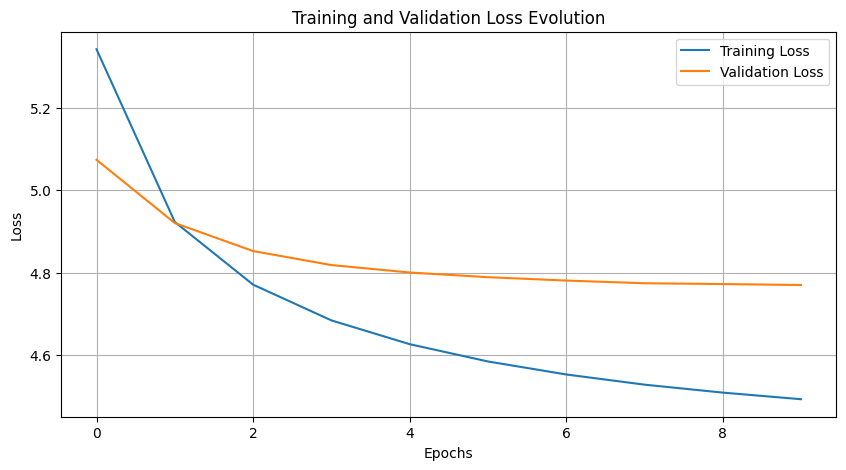

In [36]:
train(
    model=model,
    n_epochs=10,
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    lr=5e-3,
)

🚧 **Question** 🚧

Plot the training and validation curves. What can you conclude from those curves?

**Answer**

TODO

## Inference

Now that the model is trained, we can use it to generate text.

🚧 **Question** 🚧

List 3 decoding algorithms.

**Answer**

- greedy decoding
- beam search
- sampling


In [38]:
y = torch.tensor([0.1, 0.3, 0.2, 0.1, 0.3])
y_topk = torch.tensor([0.3, 0.2, 0.3])
y = y_topk / y_topk.sum()
print(y)
sample = torch.random.multinomial(weights=y, n=1)

tensor([0.3750, 0.2500, 0.3750])


AttributeError: module 'torch.random' has no attribute 'multinomial'

🚧 **TODO** 🚧

Implement greedy decoding and sampling algorithms.

In [46]:
output_tokens = []
model.eval()
input_sentence = "the football game"
print("Input text:", input_sentence)
tokenized_sentence = tokenizer.encode(input_sentence)[:-1]
input_ids = torch.tensor([tokenized_sentence])
attention_mask = torch.ones_like(input_ids)
print("Input tensor:", input_ids)
with torch.no_grad():
    for i in range(20):
        logits = model(input_ids.to(DEVICE), attention_mask.to(DEVICE))
        next_token = logits[0, -1].argmax().to(DEVICE) # 0 <= argmax <= V
        input_ids = torch.cat([input_ids.to(DEVICE), next_token.reshape(1, 1)], dim=-1)
        attention_mask = torch.ones_like(input_ids)
        print(tokenizer.decode(input_ids[0].tolist()))

Input text: the football game
Input tensor: tensor([[10001,     0,  2049,   455]])
<BOS> the football game is
<BOS> the football game is a
<BOS> the football game is a <UNK>
<BOS> the football game is a <UNK> of
<BOS> the football game is a <UNK> of a
<BOS> the football game is a <UNK> of a <UNK>
<BOS> the football game is a <UNK> of a <UNK> <UNK>
<BOS> the football game is a <UNK> of a <UNK> <UNK> <UNK>
<BOS> the football game is a <UNK> of a <UNK> <UNK> <UNK> ,
<BOS> the football game is a <UNK> of a <UNK> <UNK> <UNK> , <UNK>
<BOS> the football game is a <UNK> of a <UNK> <UNK> <UNK> , <UNK> ,
<BOS> the football game is a <UNK> of a <UNK> <UNK> <UNK> , <UNK> , <UNK>
<BOS> the football game is a <UNK> of a <UNK> <UNK> <UNK> , <UNK> , <UNK> ,
<BOS> the football game is a <UNK> of a <UNK> <UNK> <UNK> , <UNK> , <UNK> , <UNK>
<BOS> the football game is a <UNK> of a <UNK> <UNK> <UNK> , <UNK> , <UNK> , <UNK> ,
<BOS> the football game is a <UNK> of a <UNK> <UNK> <UNK> , <UNK> , <UNK> , <UNK> 

In [40]:
logits = torch.randn(10000)
logits.argmax()

tensor(8117)

🚧 **Question** 🚧

How could speed up the decoding process?

**Answer**

Cache the computation of the Key and Value in the attention mechanism.